# Intermittent Fasting - A Statistical Self-Study

This study will help me learn how food and excercise are affecting my weight and overall well-being. I am using historical data (unfortenately not continuous) exported from myfitnesspal acount. It covers a period of 6 years of unsuccessfull weight management strategies. 

Since 07.12.2017 I have decided to try a new strategy called Intermittent Fasting. I came accross this strategy in a youtube video from Dr. Jason Fung who advocates the health benefits from fasting in general. And so after conducting some research on the topic I decided to follow the so called "Warrior Diet" proposed from Ori Hofmekler. However I took the idea further and  restricted the eating plan even more by combining it with Low Carbohydrate Diet.

So in the end I eat only once a day, usually at dinner, and when I do that I try to minimize the amount of strachy carbohydrates in my meals. In simple words - no rice, bread or potatoes.

## Table of Contents
1. Data description
2. Loading and manipulating the data
3. Exploratory data analysis
4. Calories Equation Model
5. Linear Regression Model
6. Regression Tree Model
7. Neural Network Model
8. Comparison and Evaluation of the different Models
9. Meal optimization
9. Insights from the data

### 1. Data Description

The data which I use is collected in my Myfitnesspal account. When I export it in a csv file format it comes in three separate files - Exercise-Summary.csv, Measurement-Summary.csv and Nutrition-Summary.csv.

**Exercise-Summary.csv**
* Date - [YYYY-MM-DD] - observation date
* Excercise - [String] - description of the exercise
* Type - [cardio/strength] - type of the exercise
* Calories - [num] - calories burned during the exercise
* Exercise Minutes - [num] - minutes spend on the exercise
* Sets - [num] - number of sets
* Reps per Set - [num] - number of repetitions per set
* Kilograms - [num] - kilograms for each repetition
* Steps - [num] - steps count from the exercise (via Google Fit / Mi Fit)

**Measurement-Summary.csv**
* Date - [YYYY-MM-DD] - observation date
* % Body Fat - [num] - percentage of body fat
* Biceps - [num] - biceps circumference in cm
* Calves - [num] - calves circumference in cm
* Hips - [num] - hips circumference in cm
* Neck - [num] - neck circumference in cm
* Tights - [num] - tights circumference in cm
* Waist - [num] - waist circumference in cm
* Weight - [num] - weight in kg

**Nutrition-Summary.csv**
* Date - [YYYY-MM-DD] - observation date
* Meal - [String] - meal name [breakfast/lunch/dinner/snack]
* Calories - [num] - number of calories for the meal
* Fat g - [num] - grams of fat for the meal
* Saturated Fat - [num] - grams of saturated fat for the meal
* Polysaturated Fat - [num] - grams of polysaturated fat for the meal
* Monosaturated Fat - [num] - grams of monosaturated fat for the meal
* Trans Fat - [num] - grams of trans fat for the meal
* Cholesterol - [num] - mg of cholesterol for the meal
* Sodium (mg) - [num] - mg of sodium for the meal
* Potassium - [num] - mg of potassium for the meal
* Carbohydrates (g) - [num] - grams of carbohydrates for the meal 
* Fiber - [num] - grams of fiber for the meal
* Sugar - [num] - grams of sugar for the meal
* Protein (g) - [num] - grams of protein for the meal
* Vitamin A - [num] - % of the recommended daily intake
* Vitamin C - [num] - % of the recommended daily intake
* Calcium - [num] - % of the recommended daily intake
* Iron - [num] - % of the recommended daily intake

### Loading and Manipulating the Data

First I will read the data I have into a pandas dataframe

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline

exercise = pd.read_csv('myfitnesspal/Exercise-Summary.csv', index_col = 0)
measurement = pd.read_csv('myfitnesspal/Measurement-Summary.csv', index_col = 0)
nutrition = pd.read_csv('myfitnesspal/Nutrition-Summary.csv', index_col = 0)

Before I start manipulating my data I want to check the exact time period which I need to use in order to sync my dataframes. You will see why I am doing this later.

In [2]:
exercise.index = pd.to_datetime(exercise.index)
measurement.index = pd.to_datetime(measurement.index)
nutrition.index = pd.to_datetime(nutrition.index)

print("Exercise Period :  ", exercise.index[0] , ' - ', exercise.index[-1])
print("Measurement Period :  ", measurement.index[0] , ' - ', measurement.index[-1])
print("Nutrition Period :  ", nutrition.index[0] , ' - ', nutrition.index[-1])

print("Overall Period: ", min(exercise.index[0],measurement.index[0],nutrition.index[0]), ' - ',
                          max(exercise.index[-1],measurement.index[-1],nutrition.index[-1]))

startDate = min(exercise.index[0],measurement.index[0],nutrition.index[0])
endDate = max(exercise.index[-1],measurement.index[-1],nutrition.index[-1])

Exercise Period :   2012-11-10 00:00:00  -  2018-02-06 00:00:00
Measurement Period :   2012-11-10 00:00:00  -  2018-02-06 00:00:00
Nutrition Period :   2012-11-10 00:00:00  -  2018-02-06 00:00:00
Overall Period:  2012-11-10 00:00:00  -  2018-02-06 00:00:00


## Data Engineering for the Excercise Dataframe
Showing the structure of the excersice dataframe

In [3]:
exercise.head()

Exercise      Type  \
Date                                                             
2012-11-10                                      Dips  Strength   
2012-11-10  Rowing, stationary, very vigorous effort    Cardio   
2012-11-10                        Step-ups, vigorous    Cardio   
2012-11-11                                  Chin-Ups  Strength   
2012-11-11                                      Dips  Strength   

            Exercise Calories  Exercise Minutes  Sets  Reps Per Set  \
Date                                                                  
2012-11-10                NaN               NaN   7.0          10.0   
2012-11-10              227.0              22.0   NaN           NaN   
2012-11-10              251.0              20.0   NaN           NaN   
2012-11-11                NaN               NaN   3.0           8.0   
2012-11-11                NaN               NaN   5.0          10.0   

            Kilograms  Steps  
Date                          
2012-11-10       36.3    NaN  
2012-11-10        NaN    NaN  
2012-11-10        NaN    NaN  
2012-11-11       36.3    NaN  
2012-11-11       36.3    NaN

The first thing which I don't like about this data is the presence of NaN values in my columns. I want to replace this with 0s so I can actually make calculations and etc.

I know that I haven't filled the variables Sets, Reps Per Set and Kilograms consistently thus there is no point keeping them for our analysis. On the other hand you can see that the dataframe have multiple rows with the same index (3 entries for the same date) my aim is to simply aggregate this data to a single value and have only one entry per day which can describe all the data in the original table.

In order to accomplish the data aggregation I will add some categorical variables to my excercise dataframe **Strength Training  - [yes/no]**


It will not be much fun to try to aggregate the dataframe in place so I will simply make a new dataframe and transfer the aggregated information into it. Another reason why I don't want to do it in place is that my index values (the dates) are not continuous, for example some of the days I haven't logged any activity. In the end I want to perform a time-series analysis of this data and I would prefer not to have "holes" in the time-series. Thus I will add all missing days and simply give them value of 0.

In [4]:
exercise.fillna(value=0, inplace=True)

exercise_agg = pd.DataFrame(-1, columns=['Calories Burned', 
                                        'Cardio Minutes', 
                                        'Strength Training'
                                       ], index=pd.date_range(start=startDate, end=endDate ,freq='D'))

exercise_agg['Calories Burned'] = exercise.groupby('Date')['Exercise Calories'].sum()
exercise_agg['Cardio Minutes'] = exercise.groupby('Date')['Exercise Minutes'].sum()
exercise_agg['Strength Training'] = exercise.groupby('Date')['Exercise Calories'].min()
exercise_agg['Steps'] = exercise.groupby('Date')['Steps'].sum()
exercise_agg.fillna(value=0, inplace=True)


def boolStrength(x):
    if x == 0.0:
        return 'yes'
    else:
        return 'no'

exercise_agg['Strength Training'] = exercise_agg['Strength Training'].apply(lambda x: boolStrength(x))

And finally we got our data in the following form:

In [5]:
exercise_agg.head()

Calories Burned  Cardio Minutes Strength Training  Steps
2012-11-10            478.0            42.0               yes    0.0
2012-11-11            577.0            55.0               yes    0.0
2012-11-12            482.0            55.0                no    0.0
2012-11-13            441.0            40.0               yes    0.0
2012-11-14              0.0             0.0               yes    0.0

## Data Engineering for the Measurement Dataframe
Showing the structure of the measurement dataframe

In [6]:
measurement.head()

% Body Fat  Biceps  Calves  Hips  Neck  Tights  Waist  Weight
Date                                                                     
2012-11-10         NaN     NaN     NaN   NaN   NaN     NaN    NaN   113.8
2012-11-11         NaN     NaN     NaN   NaN   NaN     NaN    NaN   114.1
2012-11-13         NaN     NaN     NaN   NaN   NaN     NaN    NaN   113.5
2012-11-18         NaN     NaN     NaN   NaN   NaN     NaN    NaN   113.9
2012-11-24         NaN     NaN     NaN   NaN   NaN     NaN    NaN   114.2

I know that my measurments for hips, neck and waist are total garbage as I measured them only once and it wasn't even a proper measurment, thus I will simply remove them from the dataframe. Next thing which I will do is to extend the time-series of measurements and add all missing days. Now the question is what will I fill for weight for the days where I actually didn't measure it. Well I will use linear interpolation to fill in all the gaps.

In [7]:
measurement.drop(['Hips','Neck','Waist'], axis=1, inplace=True)

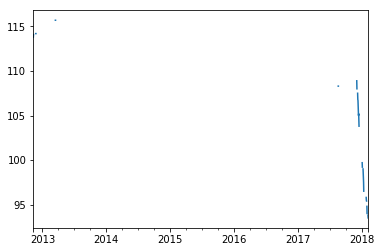

In [8]:
measurement_agg = pd.DataFrame(-1, columns=['Weight', 
                                            'dW',
                                            'Age',
                                            'BMI',
                                            'Height'
                                           ], index=pd.date_range(start=startDate, end=endDate ,freq='D'))

measurement_agg['Weight'] = measurement.groupby('Date')['Weight'].mean()
measurement_agg['Weight'].plot.line()

Look at the gaps in weight measrements above. Let's fix this

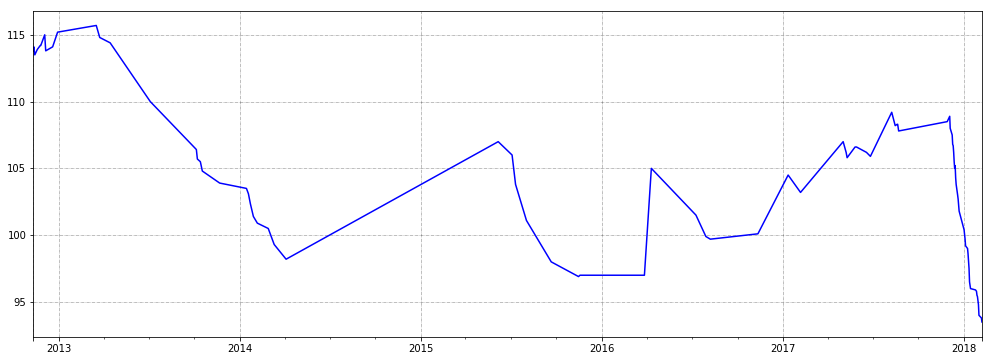

In [9]:
fig, axes = plt.subplots()
fig.set_size_inches(17, 6)

measurement_agg['Weight'].interpolate(inplace=True)
measurement_agg['Weight'].plot.line(color='b')
axes.grid(color='black', alpha=0.5, linestyle='-.', linewidth=0.5)

In [10]:
measurement_agg.head()

Weight  dW  Age  BMI  Height
2012-11-10  113.80  -1   -1   -1      -1
2012-11-11  114.10  -1   -1   -1      -1
2012-11-12  113.80  -1   -1   -1      -1
2012-11-13  113.50  -1   -1   -1      -1
2012-11-14  113.58  -1   -1   -1      -1

Now let's fill in the data in the rest of the columns:

In [11]:
measurement_agg['Height'] = 1.76  #constant durting the entire period
measurement_agg['BMI'] = np.round(measurement_agg['Weight'] / measurement_agg['Height']**2,2)
measurement_agg['Age'] = np.round((measurement_agg.index - pd.Timestamp('1988-06-07')) / pd.Timedelta(days=365),1)
measurement_agg['dW'] = measurement_agg['Weight'].diff(periods=1)
measurement_agg.at[measurement_agg.index[0],'dW'] = 0

measurement_agg.fillna(value=0, inplace=True)
measurement_agg.head()

Weight    dW   Age    BMI  Height
2012-11-10  113.80  0.00  24.4  36.74    1.76
2012-11-11  114.10  0.30  24.4  36.83    1.76
2012-11-12  113.80 -0.30  24.4  36.74    1.76
2012-11-13  113.50 -0.30  24.5  36.64    1.76
2012-11-14  113.58  0.08  24.5  36.67    1.76

## Data Engineering for the Nutrition Dataframe
Showing the structure of the nutrition dataframe

In [12]:
nutrition.head()

Meal  Calories  Fat (g)  Saturated Fat  Polyunsaturated Fat  \
Date                                                                           
2012-11-10  Breakfast     230.0     18.8            2.6                  4.0   
2012-11-10      Lunch     805.0     35.0           14.7                  0.0   
2012-11-10     Dinner     829.2     56.1           22.6                  3.7   
2012-11-11  Breakfast     574.0     28.4           18.7                  0.0   
2012-11-11      Lunch     805.0     35.0           14.7                  0.0   

            Monounsaturated Fat  Trans Fat  Cholesterol  Sodium (mg)  \
Date                                                                   
2012-11-10                  8.0        0.0          0.0        120.2   
2012-11-10                 11.9        0.0        182.0       2597.0   
2012-11-10                 19.5        0.0          0.0        281.0   
2012-11-11                  0.0        0.0          0.0        186.0   
2012-11-11                 11.9        0.0        182.0       2597.0   

            Potassium  Carbohydrates (g)  Fiber  Sugar  Protein (g)  \
Date                                                                  
2012-11-10      190.0                5.4    3.2    1.2         12.8   
2012-11-10        0.0               91.0   22.4    0.0         35.0   
2012-11-10     1627.5               74.0    7.5   72.0         25.7   
2012-11-11        0.0               60.7    0.0   53.9         18.5   
2012-11-11        0.0               91.0   22.4    0.0         35.0   

            Vitamin A  Vitamin C  Calcium  Iron  
Date                                             
2012-11-10        0.0        0.0     34.0   8.0  
2012-11-10        0.0        0.0      0.0   0.0  
2012-11-10       89.6      127.8     17.8  12.2  
2012-11-11        0.0        0.0      0.0   0.0  
2012-11-11        0.0        0.0      0.0   0.0

For this dataframe I again see that we have multiple entries per day which I don't like at all. The first task would be aggregation into a new data frame. Every time we do aggregation we lose from the original data. Thus I have to add some categorical variables so I don't compromise my analysis.

In [13]:
nutrition_agg = pd.DataFrame(0, columns=[   'Number of Meals', 
                                            'Mean Calories per Meal',
                                            'Max Calories per Meal',
                                            'Min Calories per Meal',
                                            'Total Calories',
                                            'Total Calories from Fat %',
                                            'Total Calories from Carbs %',
                                            'Total Calories from Protein %',
                                            'Total Amount of Nutrients g'
                                           ], index=pd.date_range(start=startDate, end=endDate ,freq='D'))

nutrition_agg['Number of Meals'] = nutrition.groupby('Date')['Meal'].count()
nutrition_agg['Total Calories'] = np.round(nutrition.groupby('Date')['Calories'].sum(),0)
nutrition_agg['Mean Calories per Meal'] = np.round(nutrition.groupby('Date')['Calories'].mean(),0)
nutrition_agg['Max Calories per Meal'] = np.round(nutrition.groupby('Date')['Calories'].max(),0)
nutrition_agg['Min Calories per Meal'] = np.round(nutrition.groupby('Date')['Calories'].min(),0)

nutrition_agg['Total Calories from Fat %'] = np.round((nutrition.groupby('Date')['Fat (g)'].sum() * 9 / 
                                              nutrition_agg['Total Calories'])*100,2) 

nutrition_agg['Total Calories from Carbs %'] = np.round((nutrition.groupby('Date')['Carbohydrates (g)'].sum() * 4 / 
                                              nutrition_agg['Total Calories'])*100,2) 

nutrition_agg['Total Calories from Protein %'] = np.round((nutrition.groupby('Date')['Protein (g)'].sum() * 4 / 
                                              nutrition_agg['Total Calories'])*100,2) 

nutrition_agg['Total Amount of Nutrients g'] = np.round(nutrition.groupby('Date')['Fat (g)'].sum() + 
                                                        nutrition.groupby('Date')['Carbohydrates (g)'].sum() +
                                                        nutrition.groupby('Date')['Protein (g)'].sum(),2)
nutrition_agg['Cholesterol mg'] = nutrition.groupby('Date')['Cholesterol'].sum()
nutrition_agg['Potassium mg'] = nutrition.groupby('Date')['Potassium'].sum()
nutrition_agg['Sodium mg'] = nutrition.groupby('Date')['Sodium (mg)'].sum()
nutrition_agg['Fiber g'] = nutrition.groupby('Date')['Fiber'].sum()
nutrition_agg['Sugar g'] = nutrition.groupby('Date')['Sugar'].sum()
nutrition_agg['Vitamin A %'] = nutrition.groupby('Date')['Vitamin A'].sum()
nutrition_agg['Vitamin C %'] = nutrition.groupby('Date')['Vitamin C'].sum()
nutrition_agg['Calcium %'] = nutrition.groupby('Date')['Calcium'].sum()
nutrition_agg['Iron %'] = nutrition.groupby('Date')['Iron'].sum()

In [14]:
nutrition_agg.fillna(value=0, inplace=True)
nutrition_agg.head()

Number of Meals  Mean Calories per Meal  Max Calories per Meal  \
2012-11-10              3.0                   621.0                  829.0   
2012-11-11              4.0                   516.0                  805.0   
2012-11-12              3.0                   978.0                 1508.0   
2012-11-13              4.0                   504.0                  805.0   
2012-11-14              3.0                   344.0                  840.0   

            Min Calories per Meal  Total Calories  Total Calories from Fat %  \
2012-11-10                  230.0          1864.0                      53.06   
2012-11-11                   72.0          2066.0                      45.74   
2012-11-12                  586.0          2934.0                      57.94   
2012-11-13                  212.0          2015.0                      40.73   
2012-11-14                    2.0          1032.0                      30.52   

            Total Calories from Carbs %  Total Calories from Protein %  \
2012-11-10                        36.57                          15.77   
2012-11-11                        42.42                          14.00   
2012-11-12                        33.16                          12.50   
2012-11-13                        42.86                          14.25   
2012-11-14                        55.04                          17.83   

            Total Amount of Nutrients g  Cholesterol mg  Potassium mg  \
2012-11-10                        353.8           182.0        1817.5   
2012-11-11                        396.4           226.6        1638.6   
2012-11-12                        523.8           197.6        2753.0   
2012-11-13                        378.9           650.6        1737.6   
2012-11-14                        223.0            80.0           0.0   

            Sodium mg  Fiber g  Sugar g  Vitamin A %  Vitamin C %  Calcium %  \
2012-11-10     2998.2     33.1     73.2         89.6        127.8       51.8   
2012-11-11     3572.8     30.8    100.4         78.4        114.7       44.2   
2012-11-12     2510.0     21.7    112.9         84.7        128.8       55.0   
2012-11-13     3496.8     36.4     74.3         88.5         93.5       48.2   
2012-11-14     2745.0      6.0     32.0         20.0         16.0       40.0   

            Iron %  
2012-11-10    20.2  
2012-11-11    14.1  
2012-11-12    28.8  
2012-11-13    69.2  
2012-11-14    72.0

## Combining The Data

As all my dataframes have in fact the same number of rows with the same key values I can simply stich the dataframes together column-wise, this is done really easy in Pandas:

In [15]:
fullData = pd.concat([nutrition_agg, exercise_agg, measurement_agg], axis=1)

In [16]:
fullData.head()

Number of Meals  Mean Calories per Meal  Max Calories per Meal  \
2012-11-10              3.0                   621.0                  829.0   
2012-11-11              4.0                   516.0                  805.0   
2012-11-12              3.0                   978.0                 1508.0   
2012-11-13              4.0                   504.0                  805.0   
2012-11-14              3.0                   344.0                  840.0   

            Min Calories per Meal  Total Calories  Total Calories from Fat %  \
2012-11-10                  230.0          1864.0                      53.06   
2012-11-11                   72.0          2066.0                      45.74   
2012-11-12                  586.0          2934.0                      57.94   
2012-11-13                  212.0          2015.0                      40.73   
2012-11-14                    2.0          1032.0                      30.52   

            Total Calories from Carbs %  Total Calories from Protein %  \
2012-11-10                        36.57                          15.77   
2012-11-11                        42.42                          14.00   
2012-11-12                        33.16                          12.50   
2012-11-13                        42.86                          14.25   
2012-11-14                        55.04                          17.83   

            Total Amount of Nutrients g  Cholesterol mg   ...    Iron %  \
2012-11-10                        353.8           182.0   ...      20.2   
2012-11-11                        396.4           226.6   ...      14.1   
2012-11-12                        523.8           197.6   ...      28.8   
2012-11-13                        378.9           650.6   ...      69.2   
2012-11-14                        223.0            80.0   ...      72.0   

            Calories Burned  Cardio Minutes  Strength Training  Steps  Weight  \
2012-11-10            478.0            42.0                yes    0.0  113.80   
2012-11-11            577.0            55.0                yes    0.0  114.10   
2012-11-12            482.0            55.0                 no    0.0  113.80   
2012-11-13            441.0            40.0                yes    0.0  113.50   
2012-11-14              0.0             0.0                yes    0.0  113.58   

              dW   Age    BMI  Height  
2012-11-10  0.00  24.4  36.74    1.76  
2012-11-11  0.30  24.4  36.83    1.76  
2012-11-12 -0.30  24.4  36.74    1.76  
2012-11-13 -0.30  24.5  36.64    1.76  
2012-11-14  0.08  24.5  36.67    1.76  

[5 rows x 27 columns]

So this was all the data which I have available. However to study the effects of the intermittent fasting I don't need all of that, as I started practicing it from **7th December 2017**. Since this date I have logged all my meals and excercies consistently, I only have some gaps for the weight as it is kind of pointless to weight yourself every day. Now I will slice the data and use only the numbers gathered after 7th Dec.

In [17]:
df = fullData['2017-12-07':]

I want to add one more column to our dataframe:

In [18]:
df.index.name = 'Date'
df['Net Calories'] = nutrition_agg['Total Calories'] - exercise_agg['Calories Burned']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Exploratory Data Analysis

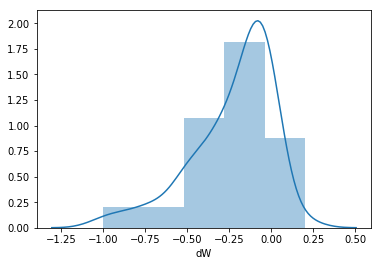

In [19]:
sns.distplot(df['dW'], bins=5)

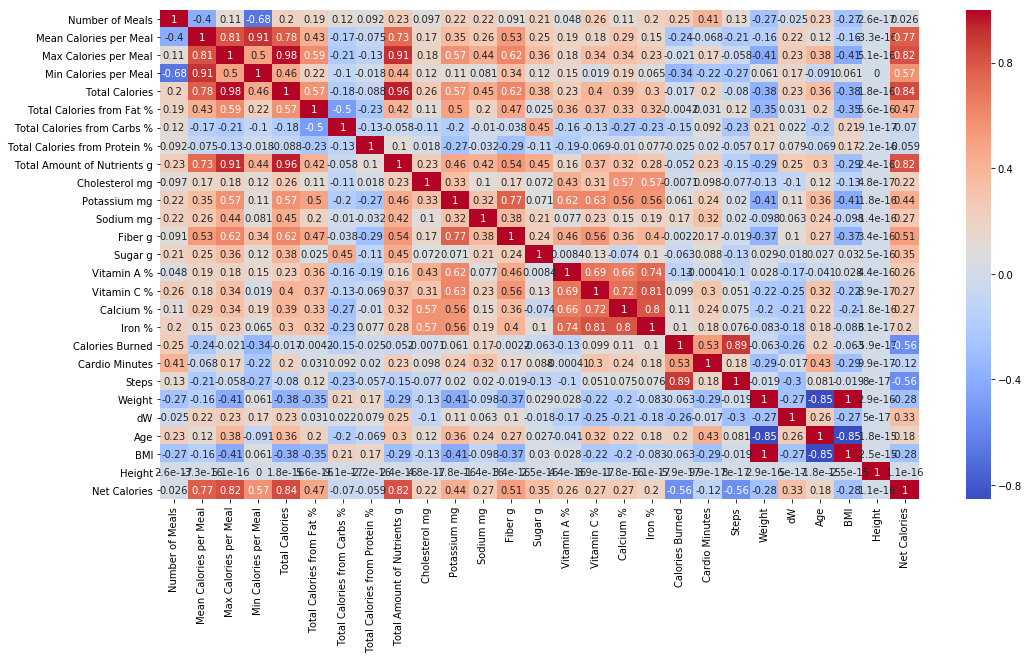

In [20]:
fig, ax = plt.subplots(figsize=(17,9)) # increasing the original size of the heatmap
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)

In [21]:
df.describe()

Number of Meals  Mean Calories per Meal  Max Calories per Meal  \
count        62.000000               62.000000              62.000000   
mean          1.370968             1055.354839            1297.983871   
std           0.550227              583.675609             564.101360   
min           0.000000                0.000000               0.000000   
25%           1.000000              604.750000             870.000000   
50%           1.000000              889.000000            1367.500000   
75%           2.000000             1486.000000            1627.000000   
max           3.000000             2460.000000            2460.000000   

       Min Calories per Meal  Total Calories  Total Calories from Fat %  \
count              62.000000       62.000000                  62.000000   
mean              813.725806     1319.903226                  56.658871   
std               778.977875      568.271890                  17.159425   
min                 0.000000        0.000000                   0.000000   
25%                 8.000000      870.000000                  48.650000   
50%               715.500000     1383.500000                  62.400000   
75%              1486.000000     1647.250000                  69.017500   
max              2460.000000     2460.000000                  76.800000   

       Total Calories from Carbs %  Total Calories from Protein %  \
count                    62.000000                      62.000000   
mean                     14.466129                      25.295806   
std                      10.466891                      12.003712   
min                       0.000000                       0.000000   
25%                       7.877500                      17.135000   
50%                      11.050000                      24.005000   
75%                      17.295000                      29.180000   
max                      57.840000                      62.120000   

       Total Amount of Nutrients g  Cholesterol mg      ...           Iron %  \
count                    62.000000       62.000000      ...        62.000000   
mean                    216.172581      240.941935      ...        39.866129   
std                      93.164134      305.028816      ...        28.343652   
min                       0.000000        0.000000      ...         0.000000   
25%                     152.950000        0.000000      ...        19.250000   
50%                     224.350000      152.100000      ...        40.650000   
75%                     278.425000      362.925000      ...        56.375000   
max                     398.600000     1312.000000      ...       128.900000   

       Calories Burned  Cardio Minutes         Steps      Weight         dW  \
count        62.000000       62.000000     62.000000   62.000000  62.000000   
mean        856.629032        6.935484  14072.354839   99.232661  -0.229839   
std         378.150167       12.521288   7399.068429    4.046805   0.245485   
min          27.000000        1.000000     27.000000   93.500000  -1.000000   
25%         628.000000        1.000000   9316.750000   95.922500  -0.337500   
50%         920.000000        1.000000  15933.000000   99.075000  -0.140000   
75%        1088.000000        4.500000  19285.250000  101.765000  -0.042500   
max        1643.000000       52.000000  25523.000000  107.625000   0.200000   

             Age        BMI        Height  Net Calories  
count  62.000000  62.000000  6.200000e+01     62.000000  
mean   29.604839  32.035000  1.760000e+00    463.274194  
std     0.063832   1.306255  1.790858e-15    687.936977  
min    29.500000  30.180000  1.760000e+00  -1157.000000  
25%    29.600000  30.970000  1.760000e+00    -41.500000  
50%    29.600000  31.985000  1.760000e+00    444.000000  
75%    29.600000  32.850000  1.760000e+00    882.750000  
max    29.700000  34.740000  1.760000e+00   2134.000000  

[8 rows x 27 columns]

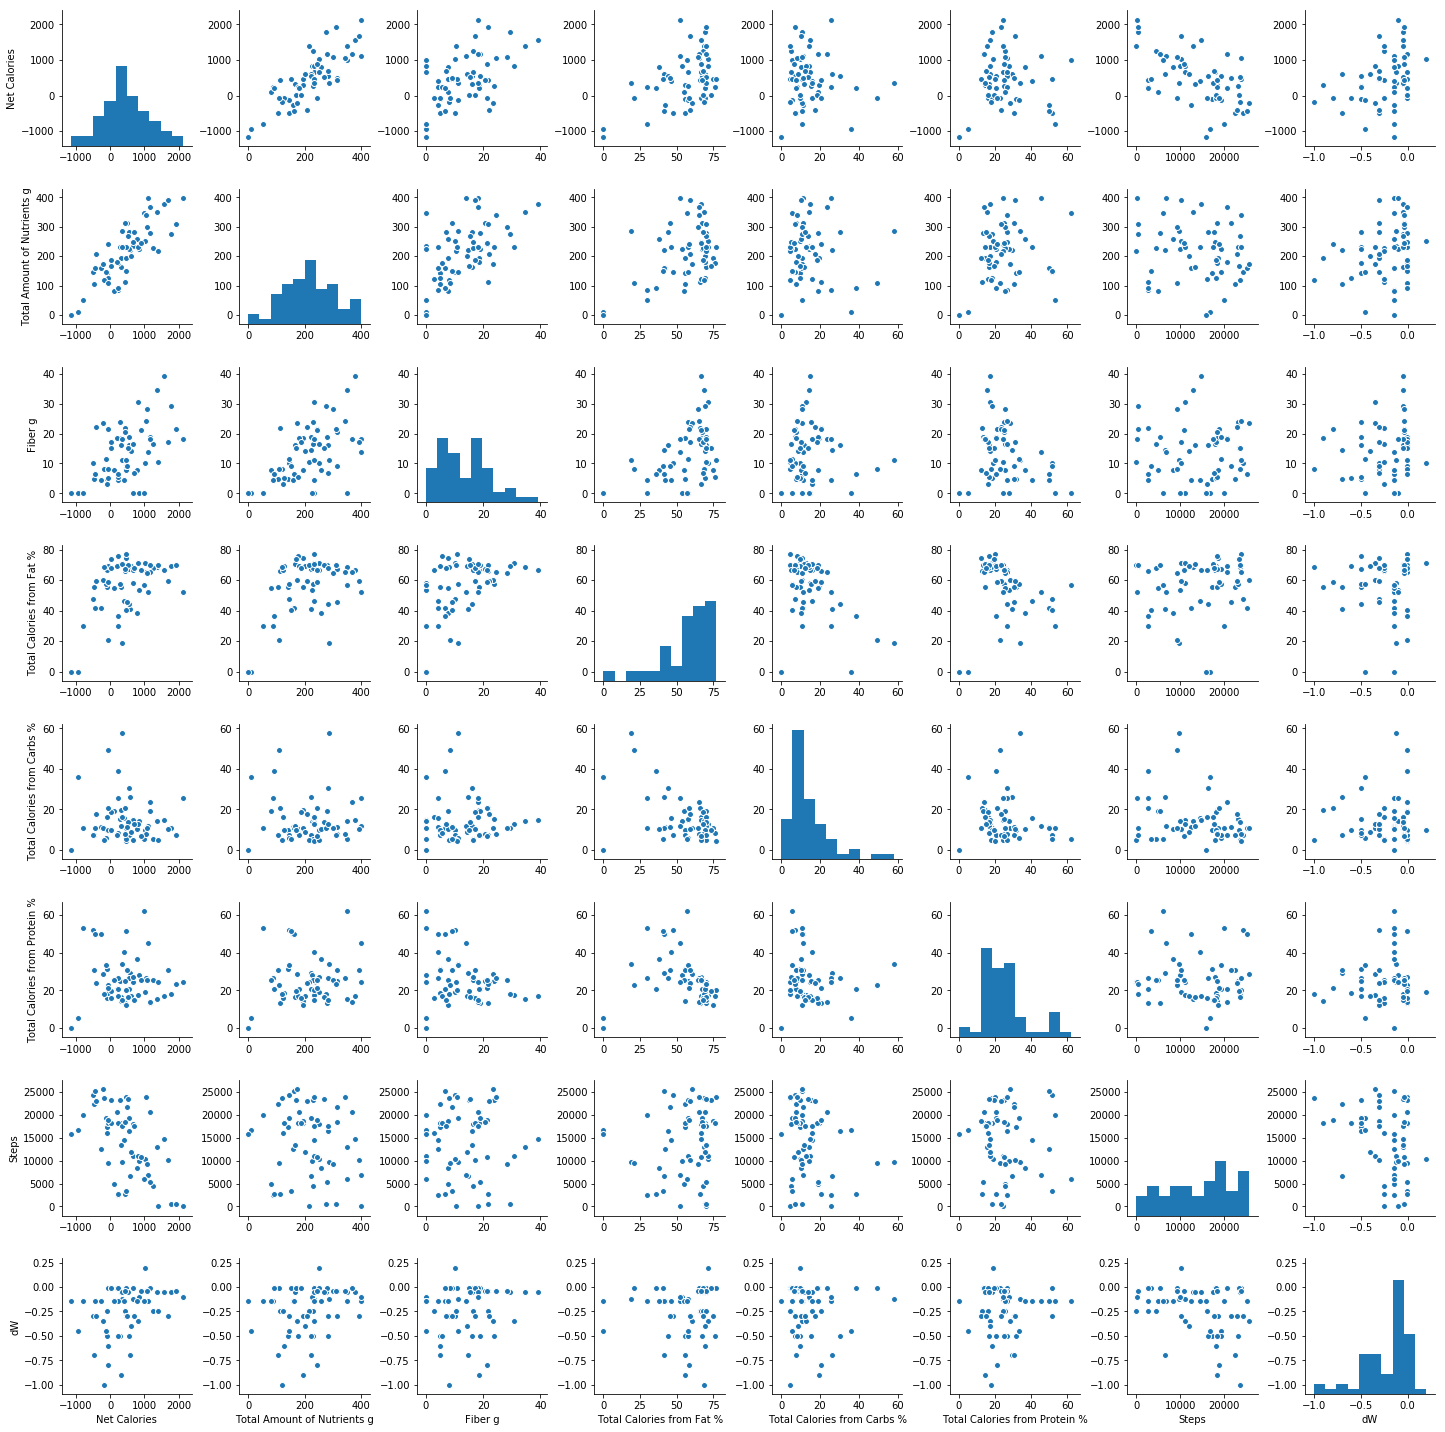

In [22]:
df_vis = df[['Net Calories', 'Total Amount of Nutrients g', 'Fiber g', 'Total Calories from Fat %', 
             'Total Calories from Carbs %', 'Total Calories from Protein %', 'Steps', 'dW']]

sns.pairplot(df_vis)

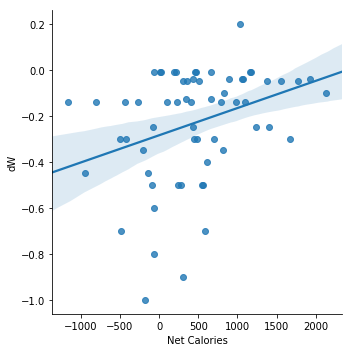

In [23]:
sns.lmplot(y='dW', x='Net Calories', data=df)

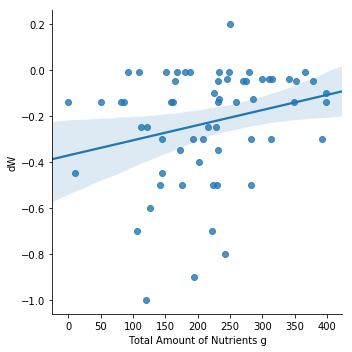

In [24]:
sns.lmplot(y='dW', x='Total Amount of Nutrients g', data=df)

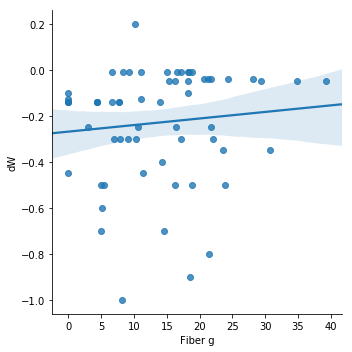

In [25]:
sns.lmplot(y='dW', x='Fiber g', data=df)

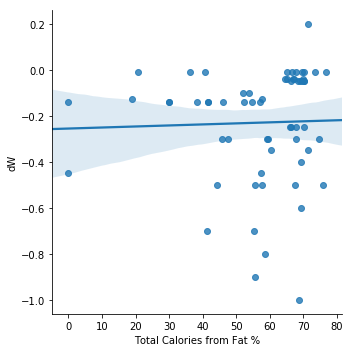

In [26]:
sns.lmplot(y='dW', x='Total Calories from Fat %', data=df)

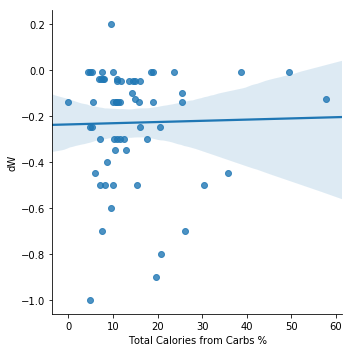

In [27]:
sns.lmplot(y='dW', x='Total Calories from Carbs %', data=df)

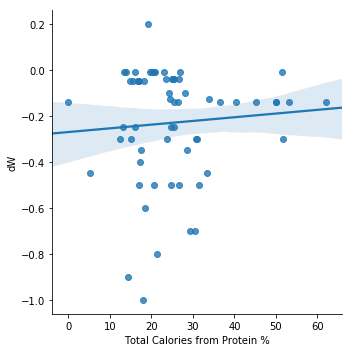

In [28]:
sns.lmplot(y='dW', x='Total Calories from Protein %', data=df)

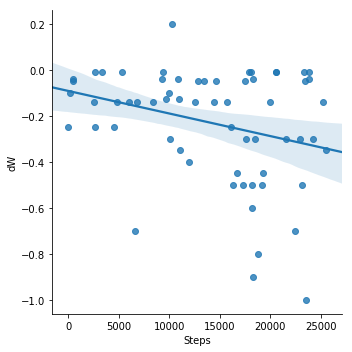

In [29]:
sns.lmplot(y='dW', x='Steps', data=df)

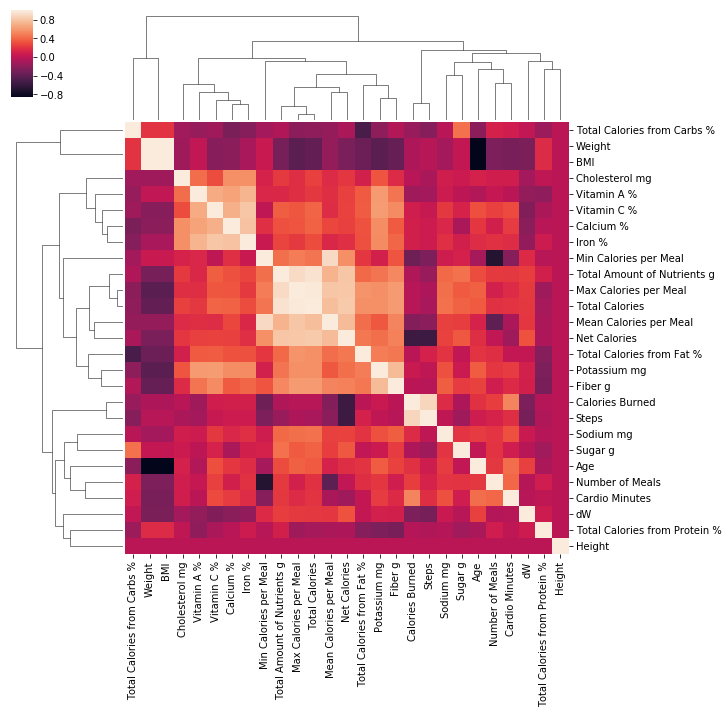

In [30]:
sns.clustermap(df.corr())

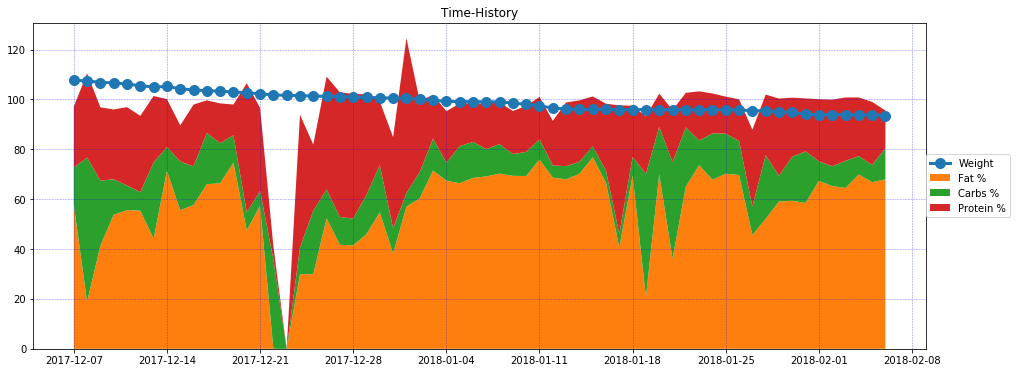

In [31]:
fig, axes = plt.subplots()

fig.set_size_inches(16, 6)

axes.plot(df.index, df['Weight'], lw=3, marker='o', markersize=10)

labels = ["Fat % ", "Carbs %", "Protein %"]
axes.stackplot(df.index, df['Total Calories from Fat %'], 
                         df['Total Calories from Carbs %'], 
                         df['Total Calories from Protein %'],
                         labels = labels)

axes.legend(loc=7, bbox_to_anchor=(1.1, 0.5))
axes.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes.set_title('Time-History');

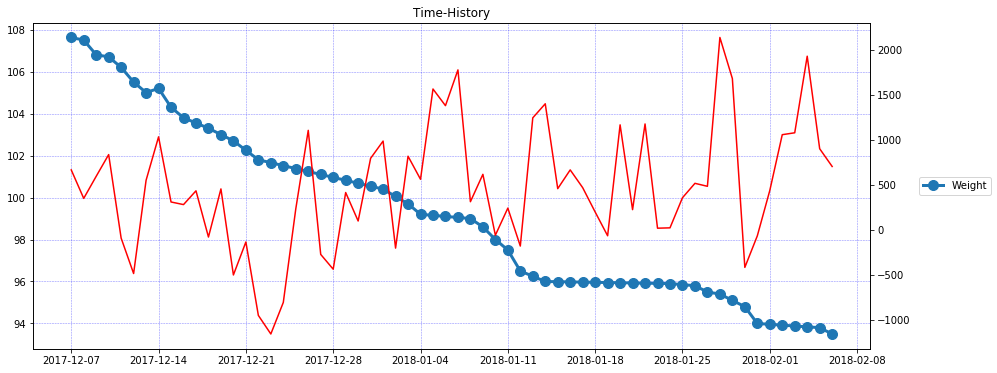

In [32]:
fig, axes = plt.subplots()

fig.set_size_inches(15, 6)

axes.plot(df.index, df['Weight'], lw=3, marker='o', markersize=10)

ax2 = axes.twinx()
ax2.plot(df.index, df['Net Calories'], 'r')

axes.legend(loc=7, bbox_to_anchor=(1.15, 0.5))
axes.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes.set_title('Time-History');

## Linear Regression

In [33]:
df.columns

Index(['Number of Meals', 'Mean Calories per Meal', 'Max Calories per Meal',
       'Min Calories per Meal', 'Total Calories', 'Total Calories from Fat %',
       'Total Calories from Carbs %', 'Total Calories from Protein %',
       'Total Amount of Nutrients g', 'Cholesterol mg', 'Potassium mg',
       'Sodium mg', 'Fiber g', 'Sugar g', 'Vitamin A %', 'Vitamin C %',
       'Calcium %', 'Iron %', 'Calories Burned', 'Cardio Minutes',
       'Strength Training', 'Steps', 'Weight', 'dW', 'Age', 'BMI', 'Height',
       'Net Calories'],
      dtype='object')

In [34]:
X = df[['Net Calories', 'Steps', 'Total Amount of Nutrients g', 'Fiber g']]

y = df['dW']

Accuracy on the training Set 21.17 %
Accuracy on the testing Set -18.94 %
MAE: 0.186748038338
MSE: 0.0590275859634
RMSE: 0.242955934201


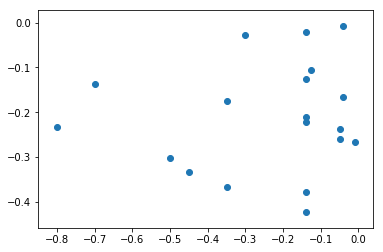

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)

prediction = lm.predict(X_test)

acc_lm_train = round(lm.score(X_train, y_train) * 100, 2)
acc_lm_test = round(lm.score(X_test, y_test) * 100 ,2)
print("Accuracy on the training Set", round(acc_lm_train,2,), "%")
print("Accuracy on the testing Set", round(acc_lm_test,2,), "%")

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

plt.scatter(y_test,prediction)

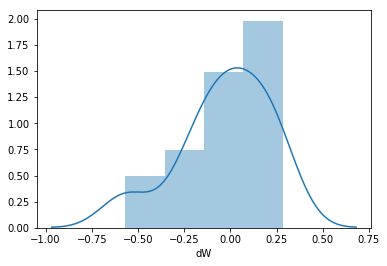

In [36]:
sns.distplot((y_test-prediction))

## Random Forest

Accuracy on the training Set 67.43 %
Accuracy on the testing Set -6.56 %
MAE: 0.189393470847
MSE: 0.0528817475289
RMSE: 0.229960317292


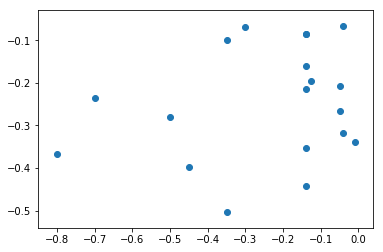

In [37]:
from sklearn.ensemble import RandomForestRegressor

features = X.columns

forest = RandomForestRegressor(n_estimators=500, random_state = 0, oob_score = True, max_depth=3)
forest.fit(X_train, y_train)

prediction = forest.predict(X_test)

forest.score(X_train,y_train)
acc_forest_train = round(forest.score(X_train, y_train) * 100, 2)
acc_forest_test = round(forest.score(X_test, y_test) * 100 ,2)

print("Accuracy on the training Set", round(acc_forest_train,2,), "%")
print("Accuracy on the testing Set", round(acc_forest_test,2,), "%")

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

plt.scatter(y_test,prediction)

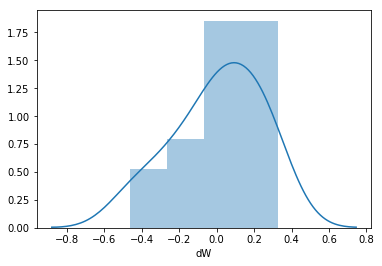

In [38]:
sns.distplot((y_test-prediction))

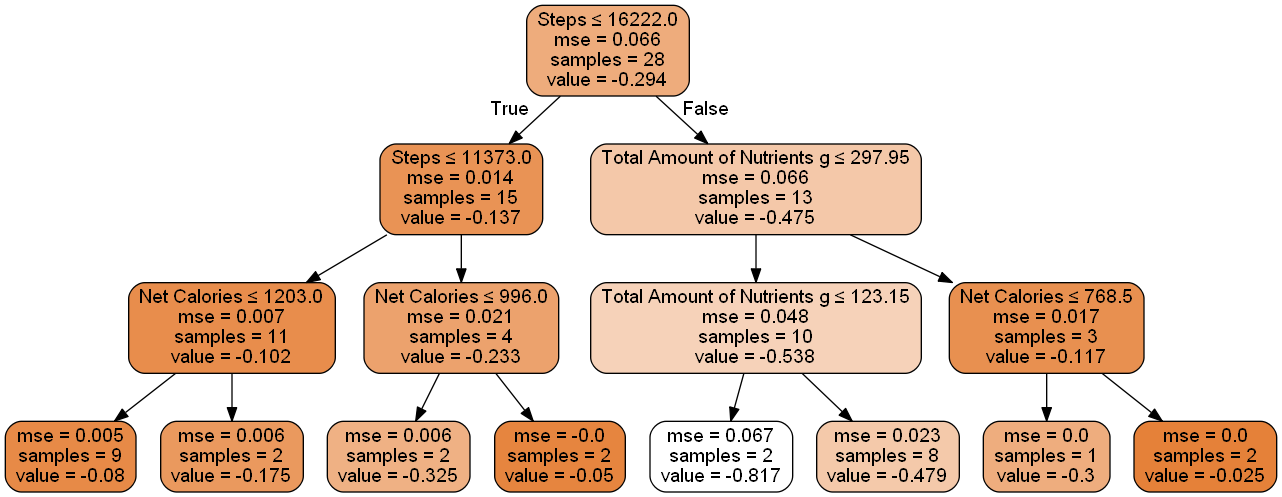

In [39]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydot

import os     
os.environ["PATH"] += os.pathsep + 'C:/anaconda3/Library/bin/graphviz'

dot_data = StringIO()
export_graphviz(forest[0], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

## Linear Regression using StatsModels not Sckikit-Learn

In [40]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

X_train = sm.add_constant(X_train)
lm1 = sm.OLS(y_train, X_train)
prediction = lm1.fit()

print(prediction.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                     dW   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     2.551
Date:                Wed, 07 Feb 2018   Prob (F-statistic):             0.0547
Time:                        23:59:57   Log-Likelihood:                 3.3829
No. Observations:                  43   AIC:                             3.234
Df Residuals:                      38   BIC:                             12.04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## New Approach Needed

It seems that I will not be able to find what causes weight loss looking only in short term results - dW. This means that I need to construct new variables and new ways to measure what is actually taking place in my body. So let's start.

But first let's check what we have so far:

In [41]:
df.head()

Number of Meals  Mean Calories per Meal  Max Calories per Meal  \
Date                                                                         
2017-12-07              1.0                  1436.0                 1436.0   
2017-12-08              2.0                   570.0                  935.0   
2017-12-09              2.0                   602.0                 1205.0   
2017-12-10              1.0                  1366.0                 1366.0   
2017-12-11              1.0                   861.0                  861.0   

            Min Calories per Meal  Total Calories  Total Calories from Fat %  \
Date                                                                           
2017-12-07                 1436.0          1436.0                      57.79   
2017-12-08                  206.0          1141.0                      18.85   
2017-12-09                    0.0          1205.0                      41.30   
2017-12-10                 1366.0          1366.0                      53.76   
2017-12-11                  861.0           861.0                      55.61   

            Total Calories from Carbs %  Total Calories from Protein %  \
Date                                                                     
2017-12-07                        14.90                          24.43   
2017-12-08                        57.84                          33.79   
2017-12-09                        26.16                          29.38   
2017-12-10                        14.23                          27.99   
2017-12-11                         9.90                          31.41   

            Total Amount of Nutrients g  Cholesterol mg      ...       \
Date                                                         ...        
2017-12-07                        233.4             0.0      ...        
2017-12-08                        285.3             0.0      ...        
2017-12-09                        222.6             0.0      ...        
2017-12-10                        225.8             0.0      ...        
2017-12-11                        142.1           117.8      ...        

            Calories Burned  Cardio Minutes  Strength Training    Steps  \
Date                                                                      
2017-12-07            772.0             5.0                 no  10994.0   
2017-12-08            793.0            17.0                 no   9634.0   
2017-12-09            612.0             1.0                 no   6631.0   
2017-12-10            532.0             1.0                 no   9932.0   
2017-12-11            954.0             1.0                 no  17256.0   

             Weight     dW   Age    BMI  Height  Net Calories  
Date                                                           
2017-12-07  107.625 -0.125  29.5  34.74    1.76         664.0  
2017-12-08  107.500 -0.125  29.5  34.70    1.76         348.0  
2017-12-09  106.800 -0.700  29.5  34.48    1.76         593.0  
2017-12-10  106.700 -0.100  29.5  34.45    1.76         834.0  
2017-12-11  106.200 -0.500  29.5  34.28    1.76         -93.0  

[5 rows x 28 columns]

In [42]:
df.columns

Index(['Number of Meals', 'Mean Calories per Meal', 'Max Calories per Meal',
       'Min Calories per Meal', 'Total Calories', 'Total Calories from Fat %',
       'Total Calories from Carbs %', 'Total Calories from Protein %',
       'Total Amount of Nutrients g', 'Cholesterol mg', 'Potassium mg',
       'Sodium mg', 'Fiber g', 'Sugar g', 'Vitamin A %', 'Vitamin C %',
       'Calcium %', 'Iron %', 'Calories Burned', 'Cardio Minutes',
       'Strength Training', 'Steps', 'Weight', 'dW', 'Age', 'BMI', 'Height',
       'Net Calories'],
      dtype='object')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

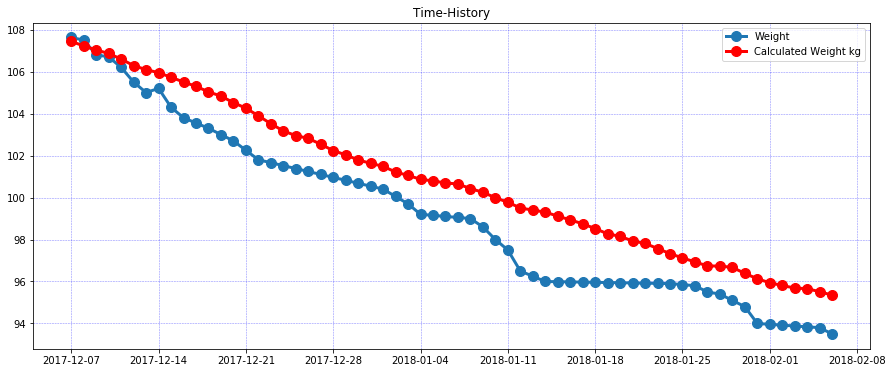

In [43]:
df['Streak'] = range(0,len(df.index),1)
df['BMR'] = 10*df['Weight'] + 625*df['Height'] + 5*df['Age'] + 5
df['Caloric Balance'] = df['Net Calories'] - df['BMR']
df['Cumulative Caloric Balance'] = df['Caloric Balance'].cumsum()
df['Calculated Weight kg'] = df.ix[0]['Weight'] + df['Cumulative Caloric Balance']/9000

fig, axes = plt.subplots()

fig.set_size_inches(15, 6)

axes.plot(df.index, df['Weight'], lw=3, marker='o', markersize=10)
axes.plot(df.index, df['Calculated Weight kg'], 'r', lw=3, marker='o', markersize=10)

axes.legend()
axes.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes.set_title('Time-History');

You see that using the simple calories equation almost got me a realistic estimate of the weight loss process. However there are other factors which drive the weight loss process, you see that they are actually accelerating it ... This is what I want to find out, what are these factors. But first let's calculate what was my exact BMR during each day:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

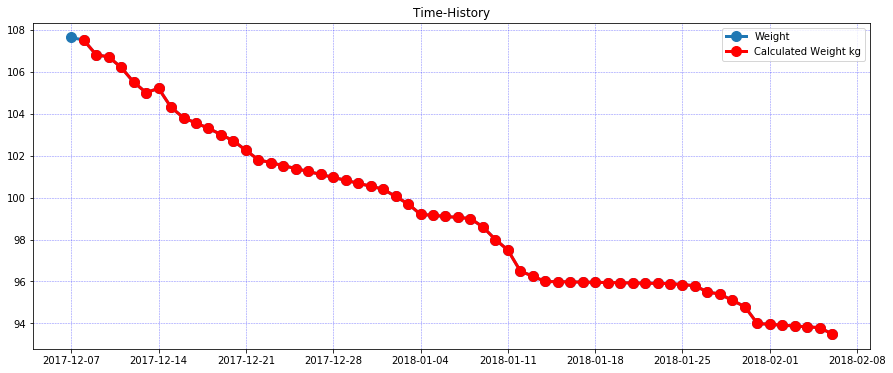

In [44]:
df['Cumulative Caloric Balance A'] = (df['Weight'] - df.ix[0]['Weight'])*9000
df['Caloric Balance A'] = df['Cumulative Caloric Balance A'].diff()
df['Daily BMR'] = df['Caloric Balance A'] - df['Net Calories']

df['Caloric Balance'] = df['Net Calories'] + df['Daily BMR']
df['Cumulative Caloric Balance'] = df['Caloric Balance'].cumsum()
df['Calculated Weight kg'] = df.ix[0]['Weight'] + df['Cumulative Caloric Balance']/9000

fig, axes = plt.subplots()

fig.set_size_inches(15, 6)

axes.plot(df.index, df['Weight'], lw=3, marker='o', markersize=10)
axes.plot(df.index, df['Calculated Weight kg'], 'r', lw=3, marker='o', markersize=10)

axes.legend()
axes.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes.set_title('Time-History');

In [45]:
df['Daily BMR'].describe()

count      61.000000
mean    -2544.000000
std      2100.072824
min     -8819.000000
25%     -3648.000000
50%     -2169.000000
75%      -965.000000
max       769.000000
Name: Daily BMR, dtype: float64

Ok now I have my daily BMR values, let's run a regression to see if there is a pattern.

In [46]:
df.columns

Index(['Number of Meals', 'Mean Calories per Meal', 'Max Calories per Meal',
       'Min Calories per Meal', 'Total Calories', 'Total Calories from Fat %',
       'Total Calories from Carbs %', 'Total Calories from Protein %',
       'Total Amount of Nutrients g', 'Cholesterol mg', 'Potassium mg',
       'Sodium mg', 'Fiber g', 'Sugar g', 'Vitamin A %', 'Vitamin C %',
       'Calcium %', 'Iron %', 'Calories Burned', 'Cardio Minutes',
       'Strength Training', 'Steps', 'Weight', 'dW', 'Age', 'BMI', 'Height',
       'Net Calories', 'Streak', 'BMR', 'Caloric Balance',
       'Cumulative Caloric Balance', 'Calculated Weight kg',
       'Cumulative Caloric Balance A', 'Caloric Balance A', 'Daily BMR'],
      dtype='object')

In [47]:
'''X = df[['Number of Meals', 
       'Total Calories', 
       'Total Calories from Fat %',
       'Total Calories from Carbs %', 
       'Total Calories from Protein %',
       'Total Amount of Nutrients g', 
       'Cholesterol mg', 
       'Potassium mg',
       'Sodium mg', 
       'Fiber g', 
       'Sugar g', 
       'Vitamin A %', 
       'Vitamin C %',
       'Calcium %', 
       'Iron %', 
       'Cardio Minutes',
       'Net Calories'
       ]]'''

X = df[[
       'Total Calories from Fat %',
       'Potassium mg',
       'Sugar g', 
       'Vitamin C %',
       'Calcium %', 
       'Iron %', 
       'Cardio Minutes',
       'Net Calories'
       ]]

'''X = df[[
       'Total Calories from Carbs %', 
       'Vitamin C %',
       'BMI',
       ]]'''

y = df['Daily BMR']
y.ix[0] = np.mean(y)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [48]:
X.head()

Total Calories from Fat %  Potassium mg  Sugar g  Vitamin C %  \
Date                                                                        
2017-12-07                      57.79           0.0      8.4          0.0   
2017-12-08                      18.85         715.4     45.4        161.6   
2017-12-09                      41.30          80.0     27.5        134.5   
2017-12-10                      53.76           0.0     27.4          0.0   
2017-12-11                      55.61         153.8     14.5        148.0   

            Calcium %  Iron %  Cardio Minutes  Net Calories  
Date                                                         
2017-12-07        0.0     0.0             5.0         664.0  
2017-12-08       23.1    38.7            17.0         348.0  
2017-12-09       20.5    37.0             1.0         593.0  
2017-12-10        0.0     0.0             1.0         834.0  
2017-12-11       23.2    38.4             1.0         -93.0

## Random Forest

In [49]:
features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [50]:
from sklearn.model_selection import GridSearchCV

estimator = RandomForestRegressor()
    
param_grid = { 
        "n_estimators"      : [10],
        "min_samples_leaf"  : range(1,21,1),
        "min_samples_split" : range(2,11,1),
        "max_depth"         : range(2,11,1),
        "oob_score"         : [True],
        "random_state"      : [0]
        }

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, return_train_score=True, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10], 'min_samples_leaf': range(1, 21), 'min_samples_split': range(2, 11), 'max_depth': range(2, 11), 'oob_score': [True], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [51]:
grid.best_score_ , grid.best_params_

(-3693081.0756396595,
 {'max_depth': 3,
  'min_samples_leaf': 3,
  'min_samples_split': 10,
  'n_estimators': 10,
  'oob_score': True,
  'random_state': 0})

Accuracy on the training Set 30.78 %
Accuracy on the testing Set -3.35 %
Out-of-bound score  0.12
RMSE on Training Set: 1706.0
RMSE on Testing Set: 2123.0


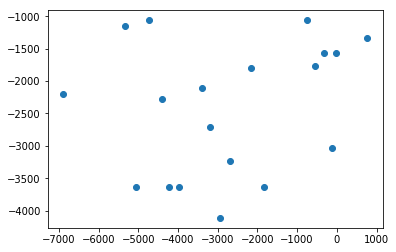

In [52]:
forest = RandomForestRegressor(n_estimators=10, random_state = 0, 
                               oob_score = True, min_samples_leaf=7, max_depth = 2,
                               min_samples_split=2)
forest.fit(X_train, y_train)

prediction = forest.predict(X_test)

print("Accuracy on the training Set", round(forest.score(X_train, y_train) * 100, 2), "%")
print("Accuracy on the testing Set", round(forest.score(X_test, y_test) * 100 ,2), "%")
print("Out-of-bound score ", round(forest.oob_score_,2))
print('RMSE on Training Set:', np.round(np.sqrt(metrics.mean_squared_error(y_train, forest.predict(X_train))),0))
print('RMSE on Testing Set:', np.round(np.sqrt(metrics.mean_squared_error(y_test, forest.predict(X_test))),0))

plt.scatter(y_test,prediction)

([<matplotlib.axis.YTick at 0x2108ff25f60>,
 <a list of 8 Text yticklabel objects>)

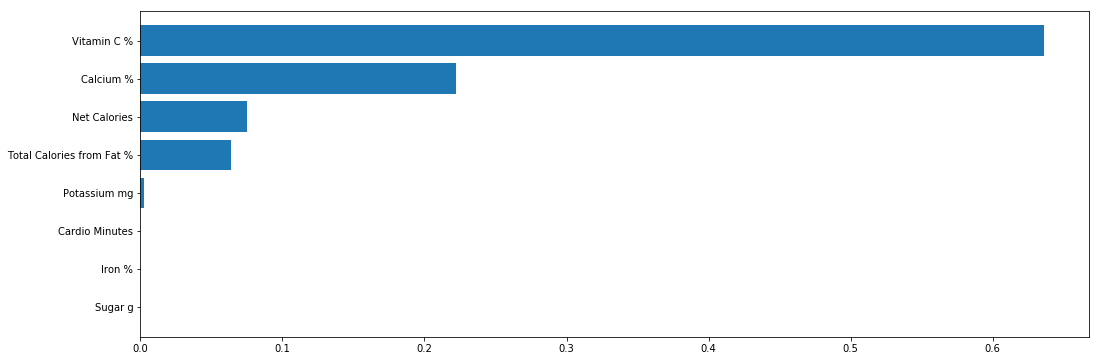

In [53]:
forest.feature_importances_

bar_x = range(len(forest.feature_importances_))

indices = np.argsort(forest.feature_importances_)
sorted_importances = []

for i in indices:
    sorted_importances.append(X.columns[i])

fig, ax = plt.subplots(figsize=(17,6))
plt.barh(bar_x, forest.feature_importances_[indices])
plt.yticks(bar_x, sorted_importances)

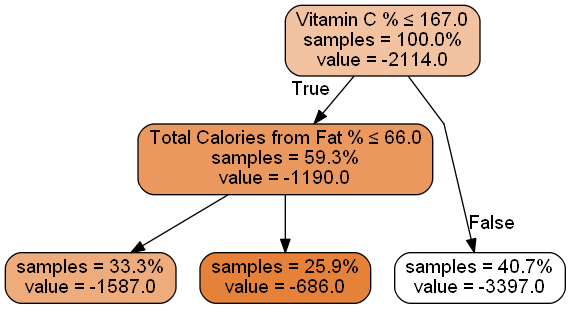

In [54]:
tree_scores = [tree.score(X_train, y_train) for tree in forest]

best_tree = tree_scores.index(max(tree_scores))

dot_data = StringIO()
export_graphviz(forest[best_tree], 
                out_file=dot_data,  
                filled=True,
                precision=0,
                special_characters=True,
                feature_names=features,
                leaves_parallel=True,
                rounded=True,
                rotate=False, 
                proportion=True, 
                impurity=False
               )
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

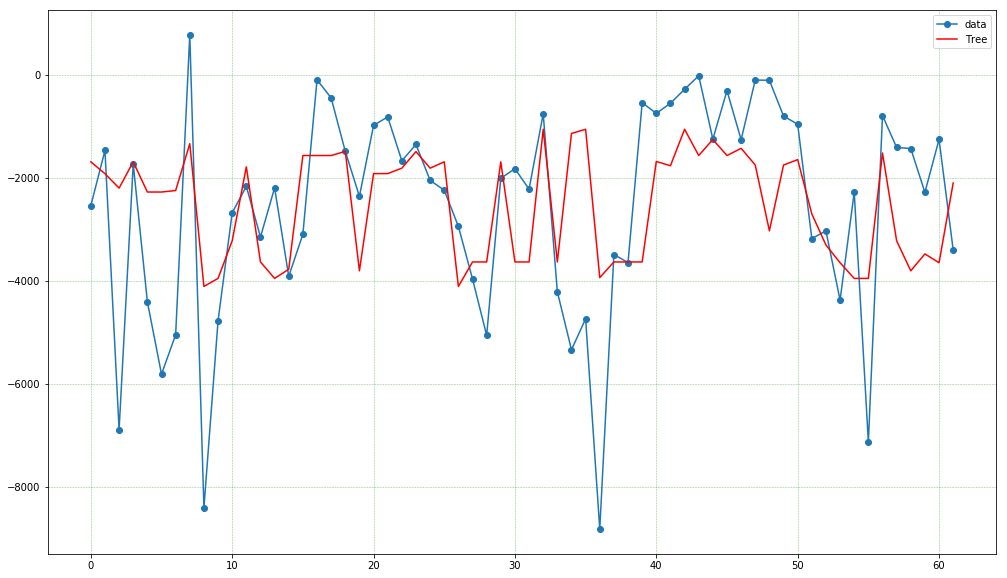

In [55]:
fig, ax = plt.subplots(figsize=(17,10))

ax.plot(df['Streak'], y, 'o-', label="data")
ax.plot(df['Streak'], forest.predict(X), 'r', label="Tree")
ax.legend(loc='best');
ax.grid(color='g', alpha=0.5, linestyle='dashed', linewidth=0.5)

## OLS

In [56]:
lm2 = sm.OLS(y, X)
prediction = lm2.fit(use_t=True, )

In [57]:
print(prediction.summary2())

                       Results: Ordinary least squares
Model:                  OLS                 Adj. R-squared:        0.690     
Dependent Variable:     Daily BMR           AIC:                   1114.4300 
Date:                   2018-02-08 00:01    BIC:                   1131.4471 
No. Observations:       62                  Log-Likelihood:        -549.21   
Df Model:               8                   F-statistic:           18.29     
Df Residuals:           54                  Prob (F-statistic):    7.03e-13  
R-squared:              0.730               Scale:                 3.3247e+06
-----------------------------------------------------------------------------
                           Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------------------
Total Calories from Fat % -24.7734   9.5165 -2.6032 0.0092  -43.4253  -6.1215
Potassium mg                0.7334   0.3859  1.9005 0.0574   -0.0229   1.4898
Sugar g  

In [58]:
prediction.predict([80,500,25,100,20,1,60,1500])

array([-1378.41496475])

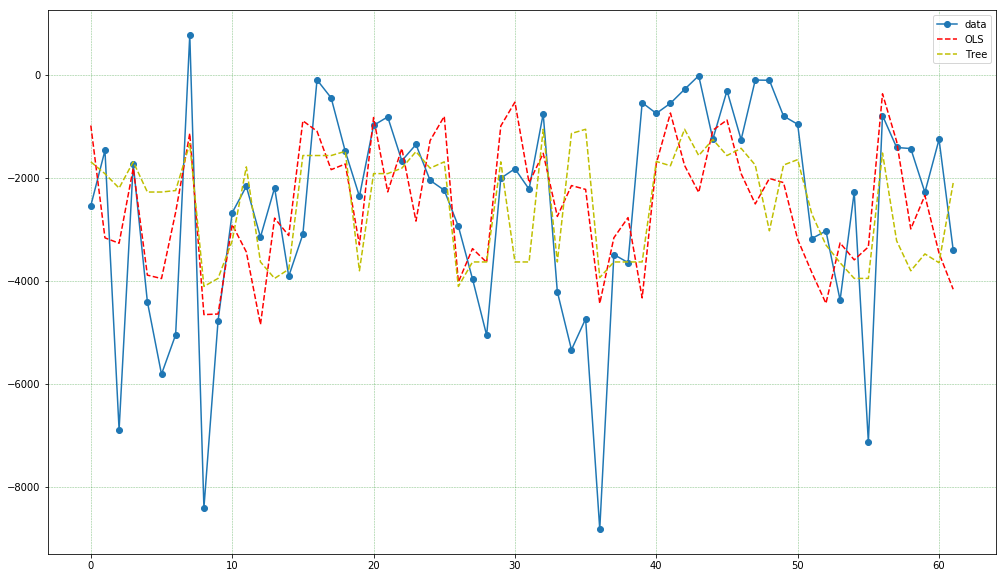

In [59]:
prstd, iv_l, iv_u = wls_prediction_std(prediction)

fig, ax = plt.subplots(figsize=(17,10))

ax.plot(df['Streak'], y, 'o-', label="data")
ax.plot(df['Streak'], prediction.fittedvalues, 'r--', label="OLS")
ax.plot(df['Streak'], forest.predict(X), 'y--', label="Tree")
#ax.plot(df['Streak'], iv_u, 'r--')
#ax.plot(df['Streak'], iv_l, 'r--')
ax.legend(loc='best');
ax.grid(color='g', alpha=0.5, linestyle='dashed', linewidth=0.5)

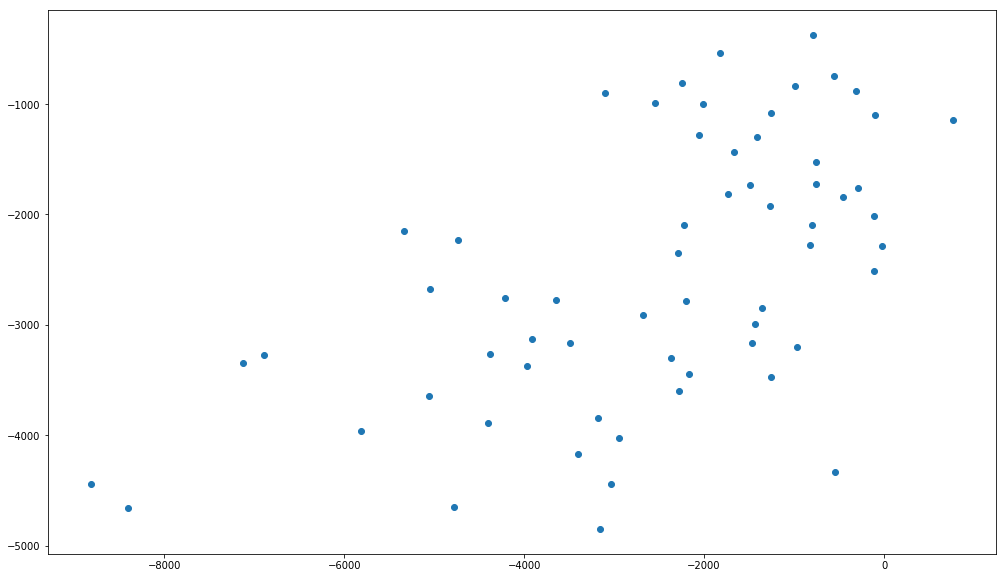

In [60]:
fig, ax = plt.subplots(figsize=(17,10))
plt.scatter(y,prediction.fittedvalues)

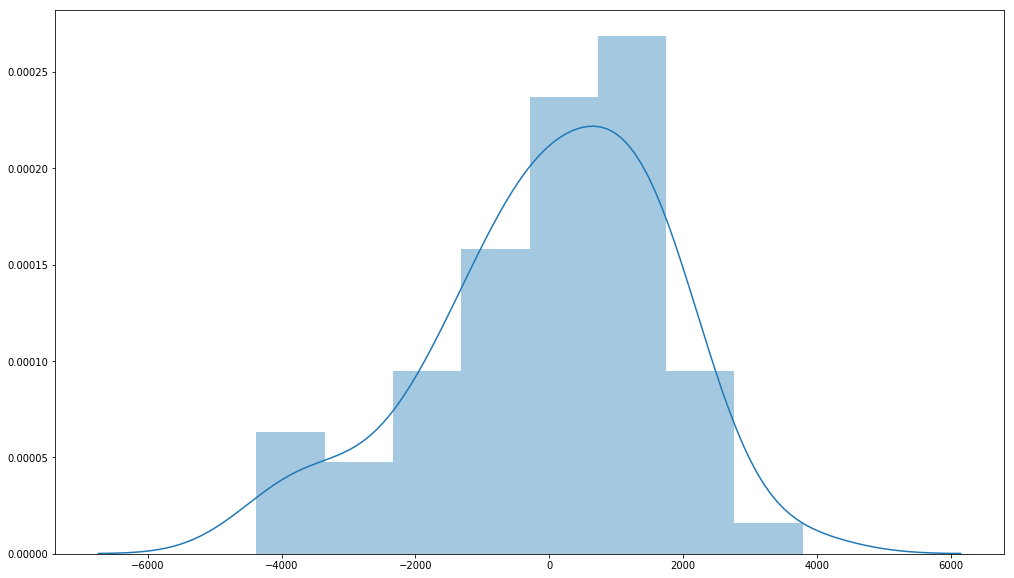

In [61]:
fig, ax = plt.subplots(figsize=(17,10))
sns.distplot(y-prediction.fittedvalues)

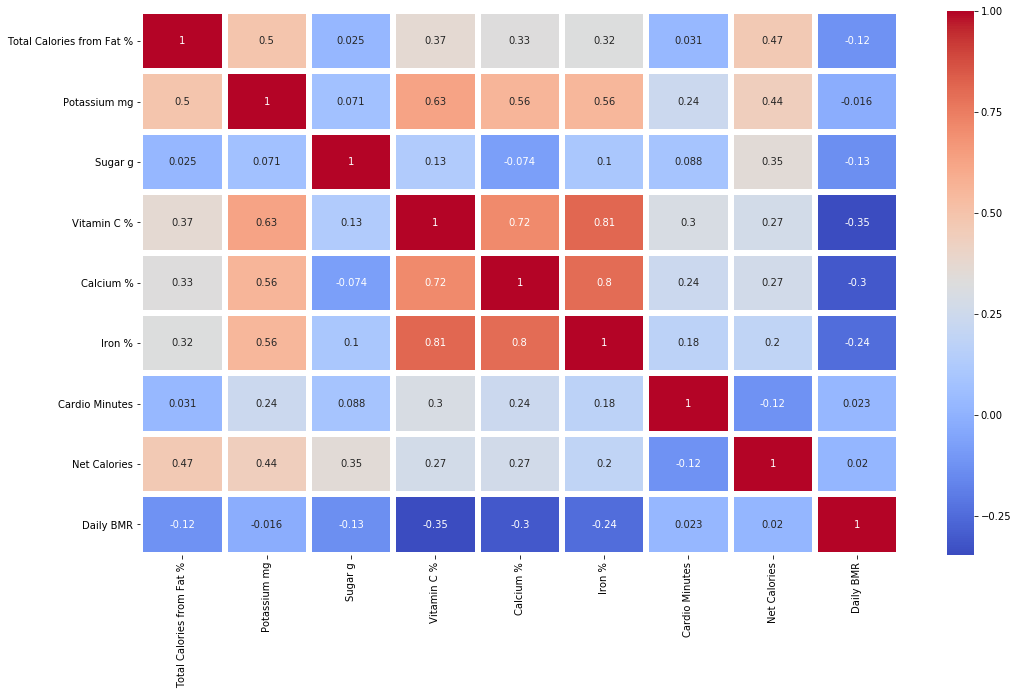

In [62]:
df_corr =  df[[
       'Total Calories from Fat %',
       'Potassium mg',
       'Sugar g', 
       'Vitamin C %',
       'Calcium %', 
       'Iron %', 
       'Cardio Minutes',
       'Net Calories', 
       'Daily BMR'
       ]]

fig, ax = plt.subplots(figsize=(17,10))
sns.heatmap(df_corr.corr(), cmap='coolwarm', annot=True, linewidths=5, )

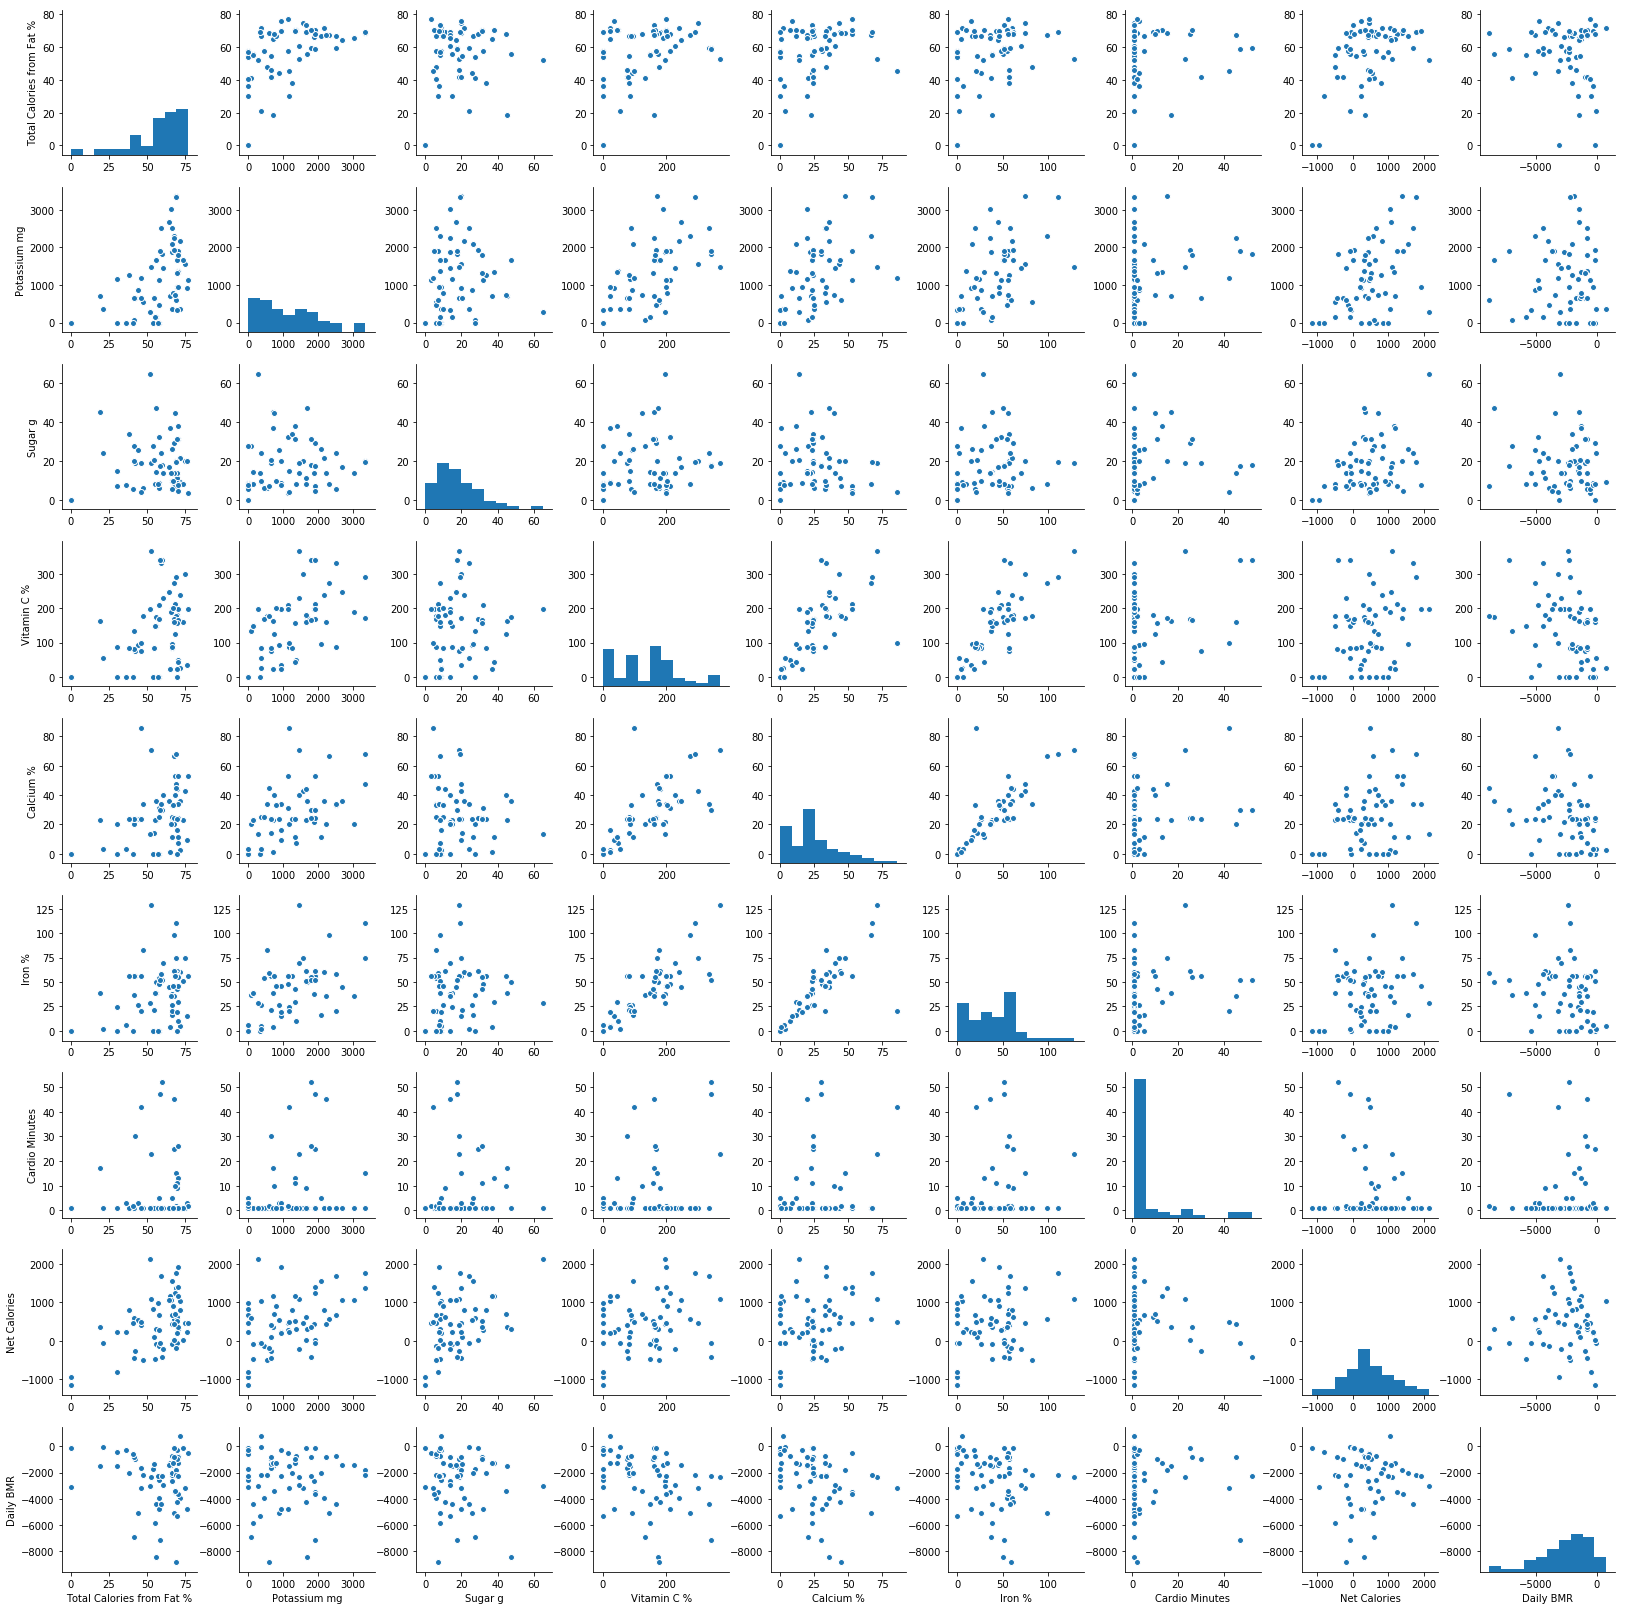

In [63]:
sns.pairplot(df_corr)

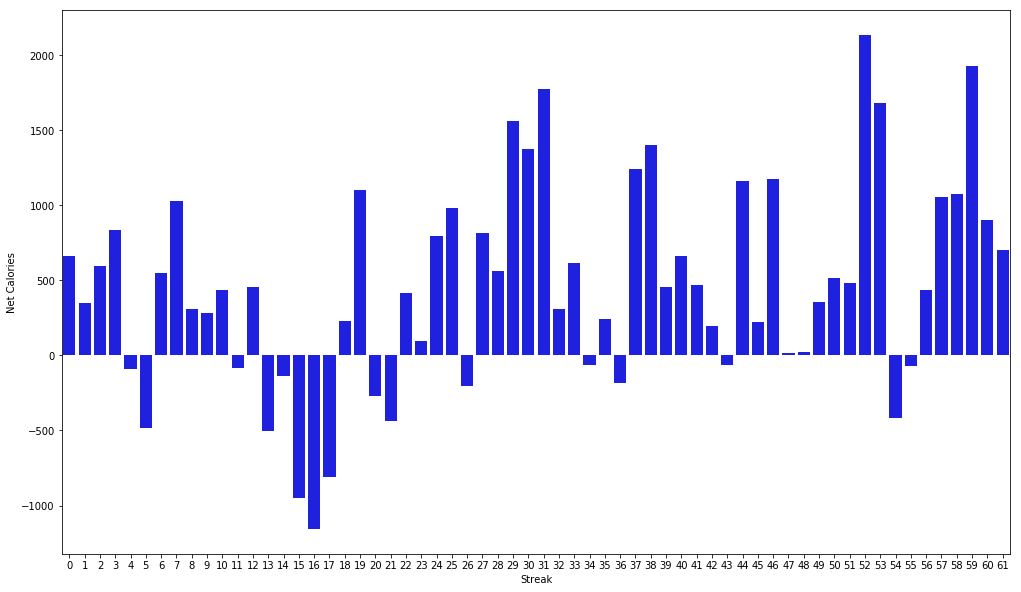

In [74]:
fig, ax = plt.subplots(figsize=(17,10))
sns.barplot(x = df['Streak'], y = df['Net Calories'], color='b')